# Creating Saliency Maps for CNNs

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Explainable AI (`XAI`) is an approach to artificial intelligence that aims to create models that are transparent, interpretable, and can provide human-understandable explanations for their decisions or predictions.**

**The goal of `XAI` is to improve the trustworthiness and reliability of AI systems, as well as to facilitate collaboration between humans and machines. One could even say that `XAI` seeks to help us create a verifiable science of AI. `XAI` techniques include methods for visualizing model internals, feature importance analysis, and rule extraction, among other methods.** 

**By providing clear and interpretable explanations for the behavior of AI models, these techniques can help us increase the transparency and accountability of these systems, which is particularly important in applications such as healthcare, finance, and law enforcement, where decisions made by AI models can have significant impacts on people's lives.** 

**`XAI` (specifically in CV applications) has formed two major threads of response: `feature visualization` and `saliency mapping`. This notebook focuses on `saliency mapping` techniques.**

![image](https://raw.githubusercontent.com/jacobgil/keras-cam/master/examples/dog.jpg)

**For a comprehensive explanation of the limitations and difficulties related to saliency mapping techniques, [we recommend this article](https://arxiv.org/abs/2002.00772), made by _[Ahmed Alqaraawi](https://arxiv.org/search/cs?searchtype=author&query=Alqaraawi%2C+A), [Martin Schuessler](https://arxiv.org/search/cs?searchtype=author&query=Schuessler%2C+M), [Philipp Weiß](https://arxiv.org/search/cs?searchtype=author&query=Wei%C3%9F%2C+P), [Enrico Costanza](https://arxiv.org/search/cs?searchtype=author&query=Costanza%2C+E), [Nadia Berthouze](https://arxiv.org/search/cs?searchtype=author&query=Berthouze%2C+N)_.**

**For a complete guide on ML Explainability, we recommend "_[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)_" (by _[Christoph Molnar](https://christophmolnar.com/)_).**

**In this notebook, we will be interpreting a CNN trained on the `CIFAR-10` dataset. The `CIFAR-10` dataset ([Canadian Institute For Advanced Research](https://en.wikipedia.org/wiki/Canadian_Institute_for_Advanced_Research)) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research, containing 60,000 32x32 color images in 10 different classes. The ten classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks (there are 6,000 images of each class).**

**Convolutional layers are the de-facto standard in image classification. However, the training of a `CNN` (Convolutional neural network) is outside the scope of this notebook. So, we are just gonna upload a pre-trained model. You can find loads of tutorials on how to train a CNN in the literature, like in [_Deep Learning with Python_](https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf), and in this [notebook](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/fa17764aa8800c388d0d298b750c686757e0861e/ML%20Explainability/CV%20Interpreter/CNN_model_maker.ipynb).**

**If you do not want to train the model, you can load the trained version in the cell below. But first, you need to download them (instructions in the `models` folder.)**


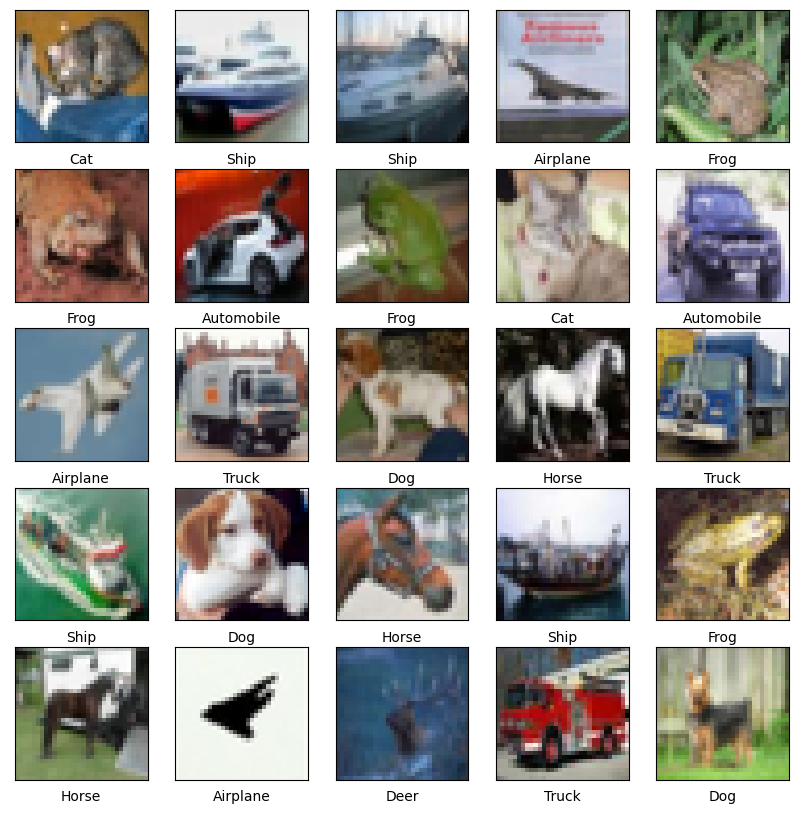

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 32, 32, 32)       155       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 32, 32, 64)       2400      
 leConv2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_2 (Separab  (None, 16, 16, 64)       4

In [2]:
import tensorflow as tf
from keras import datasets
import matplotlib.pyplot as plt
from keras.utils import np_utils

(_, _), (x_test, y_test) = datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])

plt.show()

model = tf.keras.models.load_model('models/Cifar_CNN_Conv2D.keras')
model.summary()

x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = np_utils.to_categorical(y_test, 10)

test_loss_score, test_acc_score = model.evaluate(x_test, y_test, verbose=0)

print(f'Loss: {round(test_loss_score, 2)}.')
print(f'Accuracy: {round(test_acc_score * 100, 2)} %.')

**Now let's write a function to return labels, predictions and images (feel free to write a better one).** 🙃

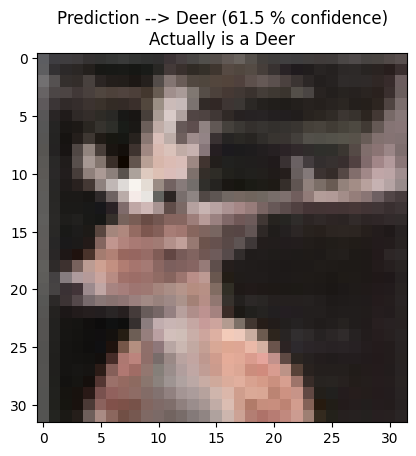

In [2]:
import numpy as np

def predict_image(x_test, y_test, sample):
    img_tensor = np.expand_dims(x_test[sample], axis=0)
    pred = [round(num, 3) for num in list(model.predict(img_tensor, verbose=0)[0])]
    plt.figure()
    plt.imshow(x_test[sample])
    plt.title(
        f'Prediction --> {class_names[np.array(pred).argmax()]} ({round(max(pred) * 100, 2)} % confidence)\nActually is a {class_names[y_test[sample].argmax()]}')
    return plt.show()

predict_image(x_test, y_test, np.random.randint(0, 9999))

## Saliency Maps with `Grad-Cam`

**Saliency maps, also known as _Class Activation Maps_ (`CAM`), are a simple technique to get the discriminative image regions used by a `CNN` to identify a specific class in the image. In other words, a saliency map lets us see which regions in the image were relevant to this class.**

**The main intutition behind this techenique is:**

- **_“how intensely the input image activates different channels” by “how important each channel is with regard to the class” is equal to how intensely the input image activates the class.”_**

**The techenique we are using in this notebook is [Grad-Cam](https://arxiv.org/abs/1610.02391), proposed by _[Ramprasaath R. Selvaraju](https://arxiv.org/search/cs?searchtype=author&query=Selvaraju%2C+R+R), [Michael Cogswell](https://arxiv.org/search/cs?searchtype=author&query=Cogswell%2C+M), [Abhishek Das](https://arxiv.org/search/cs?searchtype=author&query=Das%2C+A), [Ramakrishna Vedantam](https://arxiv.org/search/cs?searchtype=author&query=Vedantam%2C+R), [Devi Parikh](https://arxiv.org/search/cs?searchtype=author&query=Parikh%2C+D), [Dhruv Batra](https://arxiv.org/search/cs?searchtype=author&query=Batra%2C+D)_.**

**Saliency maps are the product of a convolutional layer, so we have to choose which layer should produce our map.**

In [3]:
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
conv2d_1
batch_normalization_1
max_pooling2d
dropout
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
max_pooling2d_1
dropout_1
conv2d_4
batch_normalization_4
conv2d_5
batch_normalization_5
max_pooling2d_2
dropout_2
flatten
dense
batch_normalization_6
dropout_3
dense_1


**We will use the last normalization layer before the head (the dense part of our network) of the model, i.e., `batch_normalization_5`.**

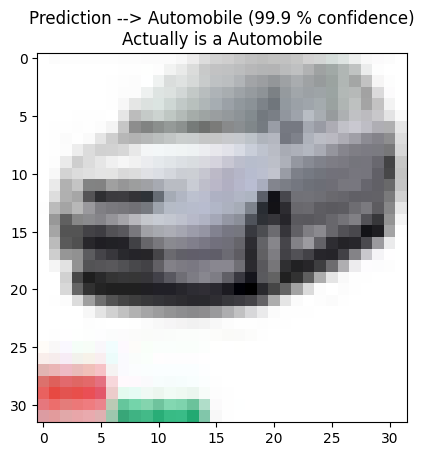

In [4]:
sample = np.random.randint(0, 9999)
predict_image(x_test, y_test, sample)
last_conv_layer_name = 'batch_normalization_5'


**Bellow we create two functions: one to generate the array of values that represent our saliency map (`create_saliency_map`), and another to generate this map as a plotly heatmap (`create_saliency_map`).**

In [5]:
import plotly.express as px

def make_gradcam_map(image, model, last_conv_layer_name, pred_index=None):
    """
    Returns a Grad-CAM (Gradient-weighted Class Activation Map) heatmap for a 
    given input image, generated using a pre-trained model and a specific 
    convolutional layer.

    Args:
        - image: A numpy array representing the input image.
        - model: A pre-trained Keras model to be used in the Grad-CAM algorithm.
        - last_conv_layer_name: A string representing the name of the convolutional 
            layer used in the Grad-CAM algorithm.
        - pred_index: An integer representing the predicted index of the model's 
            output, used in the Grad-CAM algorithm. Defaults to None.

    Returns:
        - A numpy array representing the Grad-CAM heatmap of the input image.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    img_array = np.expand_dims(image, axis=0)
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_saliency_map(heatmap):
    """
    Create a saliency map from a given heatmap.

    Args:
        heatmap (numpy.ndarray): The heatmap to create the saliency map from.

    Returns:
        None.
    """
    saliency_map = np.maximum(heatmap, 0)
    saliency_map /= np.max(saliency_map)


    fig = px.imshow(saliency_map,
                    title=f'Saliency Map',
                    text_auto=True)
    fig.update_layout({
        'template': 'plotly_dark',
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title_x': 0.5,
        'coloraxis_showscale': False
    })

    return fig.show()

model.layers[-1].activation = None
create_saliency_map(make_gradcam_map(x_test[sample], model, last_conv_layer_name))

**With this saliency map, we can combine the original image with the map to generate an "_attention map_", i.e. _which areas of the image does the model assign more weight to generate its classification_.  We are doing this by creating a function called `display_gradcam`.**

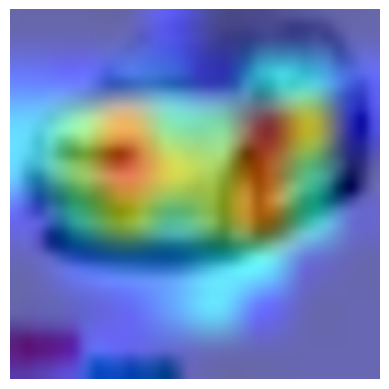

In [6]:
from matplotlib import cm

def display_gradcam(img, heatmap, alpha):
    """
    Displays the Grad-CAM visualization of an image.

    Args:
        img (numpy.ndarray): Input image.
        heatmap (numpy.ndarray): The heatmap obtained from Grad-CAM.
        alpha (float): The weight of the heatmap during blending.

    Returns:
        None.
    """
    imge = np.expand_dims(img, axis=0)[0]

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap('jet')

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((imge.shape[1], imge.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + imge
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    superimposed_img = superimposed_img.resize((150, 150))
    plt.figure()
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

saliency_map = make_gradcam_map(x_test[sample], model, last_conv_layer_name)
display_gradcam(x_test[sample], saliency_map, 0.005)

**Other Grad-CAM examples can be loaded from the `saliency_maps` folder. You will find many examples of `saliency maps` generated with this technique.**

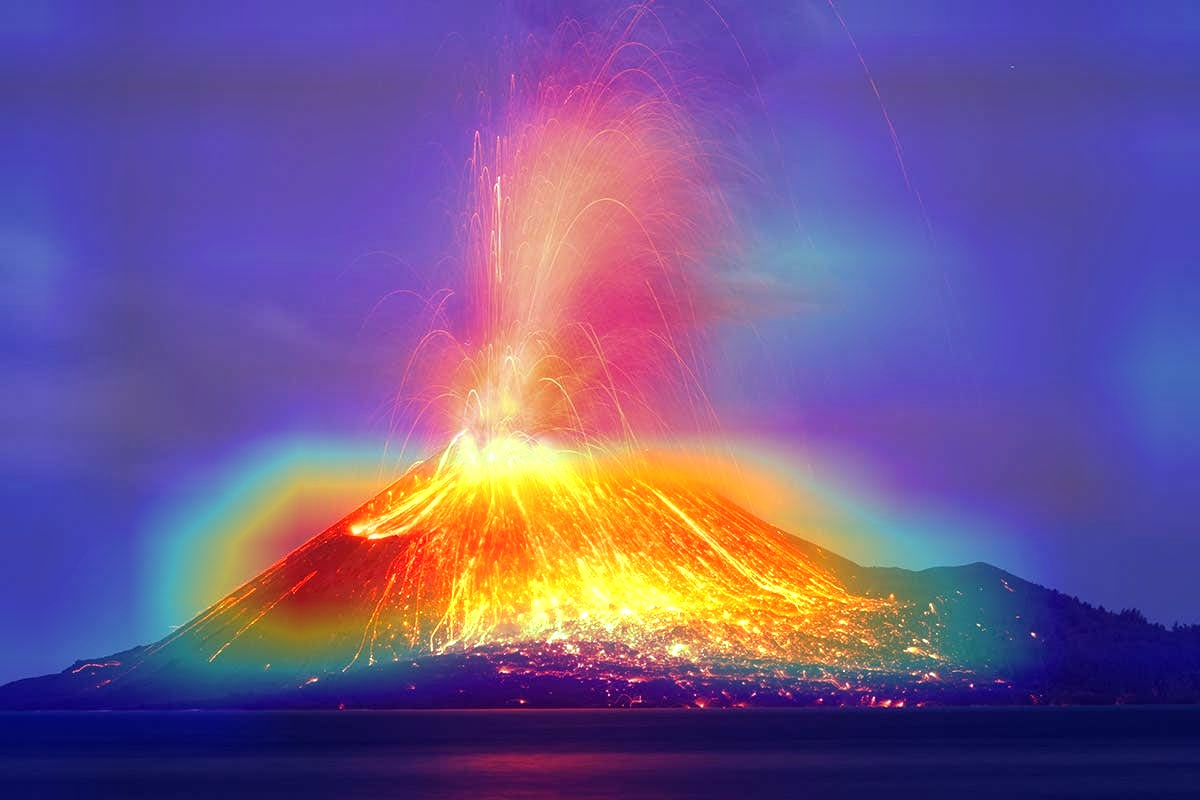

In [7]:
from IPython.display import Image
display(Image(filename=r'saliency_maps/volcano_CAM.jpg'))

**You can use these functions to create Saliency Maps for any Keras-based model. You can also load some of the many models that come with `TensorFlow` to explore the type of maps that their classifications generate (e.g., `VGG16`, `MobileNetV2`, etc.)** 🙃

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
